## 17. 다음에 볼 영화 예측하기

### [ 목  차 ]

Step 1. 데이터의 전처리   
Step 2. 미니 배치의 구성   
Step 3. 모델 구성   
Step 4. 모델 학습   
Step 5. 모델 테스트   

[ 회  고 ]


### STEP1. 데이터의 전처리

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 필요 모듈 import

import datetime as dt
from pathlib import Path
import os
from datetime import datetime

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [4]:
# 데이터 가져오기

data_path = Path('/content/drive/MyDrive/LMS/E_17/') 
train_path = data_path / 'ratings.dat'

In [5]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [9]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [10]:
# 유저 수, 아이템 수 확인

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [11]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지 확인

session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [12]:
print(f'각 세션 길이의 중앙값: {session_length.median()}')
print(f'각 세션 길이의 평균값: {session_length.mean()}')
print(f'각 세션 길이의 최솟값: {session_length.min()}')
print(f'긱 세션 길이의 최댓값: {session_length.max()}')
print(f'99.9% 세션의 길이: {session_length.quantile(0.999)}')

각 세션 길이의 중앙값: 96.0
각 세션 길이의 평균값: 165.5975165562914
각 세션 길이의 최솟값: 20
긱 세션 길이의 최댓값: 2314
99.9% 세션의 길이: 1343.181000000005


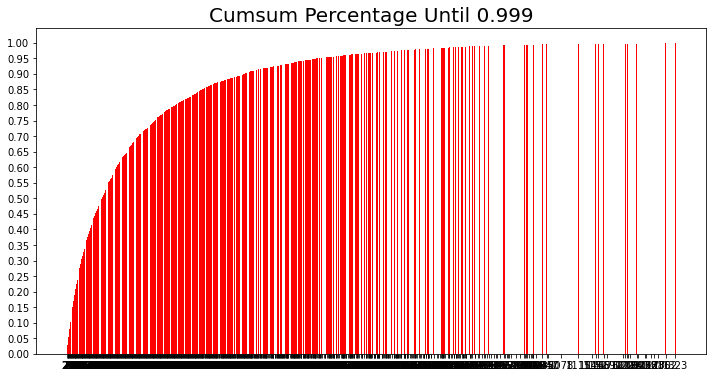

In [14]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합 시각화

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

plt.figure(figsize=(12, 6))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [15]:
# Sesstion Time

from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


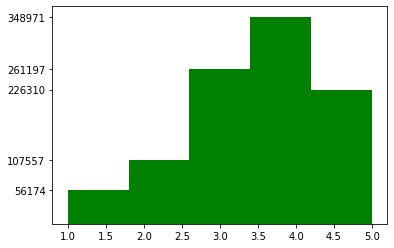

In [17]:
# 평점의 Histogram

plt.hist(data['Rating'], bins=5, color='g')
plt.yticks(data['Rating'].value_counts())
plt.show()

In [18]:
# 평점 4 이상만 남김

data = data[data['Rating']>=4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   UserId  575281 non-null  int32         
 1   ItemId  575281 non-null  int32         
 2   Rating  575281 non-null  int32         
 3   Time    575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 15.4 MB


In [19]:
# 길이가 1인 세션 제거
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

data = cleanse_recursive(data, shortest=5, least_click=15)
data    

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


In [20]:
# Train / Valid / Test split

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [22]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 558307
	 Sessions: 6031
	 Items: 2562
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 03:58:17

* valid Set Stats Info
	 Events: 6211
	 Sessions: 365
	 Items: 1808
	 First Time : 2002-03-05 04:38:49
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 4729
	 Sessions: 311
	 Items: 1512
	 First Time : 2002-09-01 19:43:16
	 Last Time : 2003-02-28 17:49:50



In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

In [26]:
# SessionDataset

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [28]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 558008, 558098, 558307], dtype=int32)

In [29]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6028, 6029, 6030])

In [30]:
# SessionDataLoader

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 45 52 22]
Label Item Idx are :       [  1  46 112  56]
Previous Masked Input Idx are []


### Step 3. 모델 구성

In [34]:
# Model Architecture

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
# Hyper-parameter Class

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [41]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(256, 1, 2562)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               392100    
                              (256, 50)]                         
                                                                 
 dropout_1 (Dropout)         (256, 50)                 0         
                                                                 
 dense_1 (Dense)             (256, 2562)               130662    
                                                                 
Total params: 522,762
Trainable params: 522,762
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

In [37]:
# Model Training

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [42]:
# 학습 시간이 다소 오래 소요됩니다.

train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:04<00:42,  2.11s/it]


	 - Recall@20 epoch 1: 0.037109
	 - MRR@20    epoch 1: 0.005073



Evaluation:   9%|▉         | 2/22 [00:03<00:39,  1.97s/it]


	 - Recall@20 epoch 2: 0.060547
	 - MRR@20    epoch 2: 0.013627



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.94s/it]


	 - Recall@20 epoch 3: 0.064453
	 - MRR@20    epoch 3: 0.021530



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.94s/it]


	 - Recall@20 epoch 4: 0.058594
	 - MRR@20    epoch 4: 0.018978



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.94s/it]

	 - Recall@20 epoch 5: 0.074219
	 - MRR@20    epoch 5: 0.022469



### Step 5. 모델 테스트

In [43]:
# Inference

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:30,  1.93s/it]

	 - Recall@20: 0.109375
	 - MRR@20: 0.030452



하이퍼 파라미터 변경 후 모델 테스트

In [48]:
# drop_rate=0.3, lr=0.01

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.01, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(256, 1, 2562)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               392100    
                              (256, 50)]                         
                                                                 
 dropout_3 (Dropout)         (256, 50)                 0         
                                                                 
 dense_3 (Dense)             (256, 2562)               130662    
                                                                 
Total params: 522,762
Trainable params: 522,762
Non-trainable params: 0
_________________________________________________________________


Evaluation:   9%|▉         | 2/22 [00:04<00:41,  2.08s/it]


	 - Recall@20 epoch 1: 0.070312
	 - MRR@20    epoch 1: 0.016787



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.93s/it]


	 - Recall@20 epoch 2: 0.083984
	 - MRR@20    epoch 2: 0.021948



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.92s/it]


	 - Recall@20 epoch 3: 0.089844
	 - MRR@20    epoch 3: 0.022422



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.91s/it]


	 - Recall@20 epoch 4: 0.089844
	 - MRR@20    epoch 4: 0.022056



Evaluation:   9%|▉         | 2/22 [00:03<00:38,  1.93s/it]

	 - Recall@20 epoch 5: 0.093750
	 - MRR@20    epoch 5: 0.024297



In [49]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:30,  1.94s/it]

	 - Recall@20: 0.117188
	 - MRR@20: 0.020193



In [50]:
# batch_size=128, hsz=128, drop_rate=0.3, lr=0.01

args = Args(tr, val, test, batch_size=128, hsz=128, drop_rate=0.3, lr=0.01, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(128, 1, 2562)]          0         
                                                                 
 GRU (GRU)                   [(128, 128),              1033728   
                              (128, 128)]                        
                                                                 
 dropout_4 (Dropout)         (128, 128)                0         
                                                                 
 dense_4 (Dense)             (128, 2562)               330498    
                                                                 
Total params: 1,364,226
Trainable params: 1,364,226
Non-trainable params: 0
_________________________________________________________________


Evaluation:  44%|████▍     | 20/45 [00:19<00:24,  1.01it/s]


	 - Recall@20 epoch 1: 0.113672
	 - MRR@20    epoch 1: 0.030849



Evaluation:  44%|████▍     | 20/45 [00:19<00:24,  1.04it/s]


	 - Recall@20 epoch 2: 0.119141
	 - MRR@20    epoch 2: 0.031873



Evaluation:  44%|████▍     | 20/45 [00:19<00:24,  1.04it/s]


	 - Recall@20 epoch 3: 0.116797
	 - MRR@20    epoch 3: 0.033885



Evaluation:  44%|████▍     | 20/45 [00:19<00:24,  1.04it/s]


	 - Recall@20 epoch 4: 0.113281
	 - MRR@20    epoch 4: 0.030956



Evaluation:  44%|████▍     | 20/45 [00:19<00:24,  1.03it/s]

	 - Recall@20 epoch 5: 0.124219
	 - MRR@20    epoch 5: 0.035417



In [51]:
test_model(model, args, test)

Evaluation:  35%|███▌      | 12/34 [00:11<00:21,  1.04it/s]

	 - Recall@20: 0.136068
	 - MRR@20: 0.037689



### 모델 테스트 비교: 

Model1: (batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)    
Model2: (batch_size=256, hsz=50, drop_rate=0.3, lr=0.01, epochs=5, k=20)   
Model3: (batch_size=128, hsz=128, drop_rate=0.3, lr=0.01, epochs=5, k=20)

<br>

|구 분|Model1|Model2|Model3|
|---|:---:|:---:|:---:|
|train_accuracy|0.0469|0.0391|0.0391|
|train_loss|5.86|5.86|5.67|
|train_Recall@20|0.074219|0.093750|0.124219|
|train_MRR@20|0.022469|0.024297|0.035417|
|test_Recall@20|**0.109375**|**0.117188**|**0.136068**|
|test_MRR@20|**0.030452**|**0.020193**|**0.037689**|



### [ 회  고 ]
  * 모델 하이퍼 파라메터 테스트에서 dropout 사용 및 hidden-size 증가의 성과개선이 확인됨
  * 함수와 클래스를 잘 사용하는 방법을 배워야겠음  : 모델 파라메터도 클래스로 관리
  * 이번이 마지막 EX, 어떻게든 끝냈는데 앞으로 Going Deeper는 어떨지 궁금해짐


< reference >    
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN
https://github.com/hidasib/GRU4Rec    
https://wikidocs.net/151537


